In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
# use this: https://medium.com/@siladityaghosh/efficient-processing-of-large-csv-files-in-python-a-data-engineering-approach-3eabe3623416

In [ ]:
gaze_data  = "/content/drive/MyDrive/masters-project/gaze_data.csv"
subsequences = "/content/drive/MyDrive/masters-project/subsequences.txt"
design = "/content/drive/MyDrive/masters-project/dr(eye)ve_design.txt"


In [ ]:
# reading the data file
gaze_data = pd.read_csv(gaze_data)

# reorganizing the data file
gaze_data = gaze_data.iloc[1: , :]
gaze_data = gaze_data.reset_index(drop=True)



In [ ]:
# reading the subsequences file
subsequences = pd.read_csv(subsequences, sep="\t")


In [ ]:
design = pd.read_csv(design, sep="\t")
design = design.T.reset_index().T.reset_index(drop=True)
design.columns = ['file_number', 'time', 'weather', 'location', 'D', 'train/test']
design.iloc[0, 0] = 1
design

,file_number,time,weather,location,D,train/test
0,1,Evening,Sunny,Countryside,D8,Training Set
1,2,Morning,Cloudy,Highway,D2,Training Set
2,3,Evening,Sunny,Highway,D3,Training Set
3,4,Night,Sunny,Downtown,D2,Training Set
4,5,Morning,Cloudy,Countryside,D7,Training Set
...,...,...,...,...,...,...
69,70,Morning,Rainy,Downtown,D3,Test Set
70,71,Night,Cloudy,Highway,D6,Test Set
71,72,Evening,Cloudy,Downtown,D2,Test Set
72,73,Night,Sunny,Countryside,D7,Test Set


# Data Exploration

In [ ]:
gaze_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1301250 entries, 0 to 1301249
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   file_number  1301250 non-null  int64 
 1   frame_etg    1301250 non-null  object
 2   frame_gar    1301250 non-null  object
 3   X            1263848 non-null  object
 4   Y            1263848 non-null  object
 5   event_type   1301250 non-null  object
 6   code         1301250 non-null  object
dtypes: int64(1), object(6)
memory usage: 69.5+ MB


In [ ]:
gaze_data.describe()

,file_number
count,1.301250e+06
mean,3.745919e+01
std,2.139711e+01
min,1.000000e+00
25%,1.900000e+01
50%,3.800000e+01
75%,5.600000e+01
max,7.400000e+01


In [ ]:
gaze_data.isnull().sum()

,0
file_number,0
frame_etg,0
frame_gar,0
X,37402
Y,37402
event_type,0
code,0


In [ ]:
# Adding Timestamp to gaze_data

FRAME_RATE = 30
FRAME_DURATION = 1/FRAME_RATE
gaze_data['frame_gar'] = pd.to_numeric(gaze_data['frame_gar'], errors='coerce')
gaze_data['timestamp'] = gaze_data['frame_gar'] * FRAME_DURATION
gaze_data

,file_number,frame_etg,frame_gar,X,Y,event_type,code,timestamp
0,1,0,0.0,313.81,256.40,Fixation,911066603,0.000000
1,1,0,0.0,313.56,258.52,Saccade,911083143,0.000000
2,1,1,1.0,292.11,259.90,Saccade,911099864,0.033333
3,1,1,1.0,185.82,306.49,Saccade,911116251,0.033333
4,1,2,2.0,143.25,322.21,Saccade,911133030,0.066667
...,...,...,...,...,...,...,...,...
1301245,74,8999,7499.0,405.71,207.12,Saccade,709796963,249.966667
1301246,74,8999,7499.0,495.73,179.57,Saccade,709813635,249.966667
1301247,74,9000,7500.0,589.77,152.12,Saccade,709830213,250.000000
1301248,74,9000,7500.0,690.76,123.23,Fixation,709847356,250.000000


# event distribution type

Analyzing the different event distributions in out gaze data, specifically for events Fixation , Saccade, and Blink.*italicized text*

In [ ]:
event_type_counts = gaze_data['event_type'].value_counts()

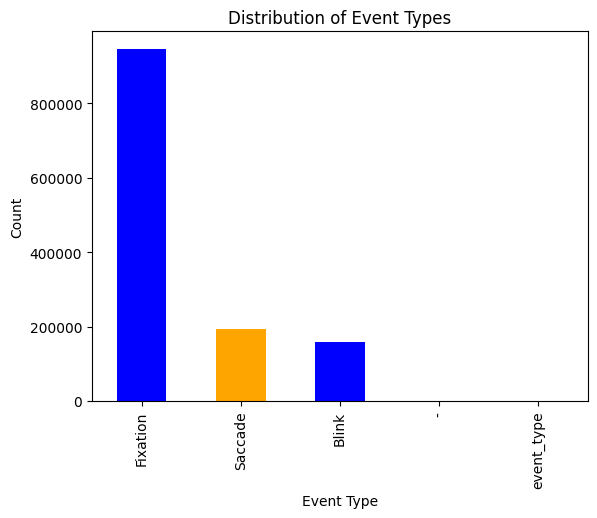

In [ ]:
# Bar plot for events fixation, saccade, and blink
event_type_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

In [ ]:
def event_counter(df):
    """
    Analyzes consecutive occurrences of events within a DataFrame.

    This function calculates two things for each event type in the DataFrame:
    1. The length of consecutive sequences of each event type.
    2. The number of times each event type appears consecutively in these sequences.

    Args:
        df (pd.DataFrame): DataFrame containing at least a column named 'event_type'.

    Returns:
        pd.Series: A Series with the count of consecutive occurrences of each event type.
    """
    result = df.groupby(df['event_type'].ne(df['event_type'].shift()).cumsum())['event_type'].value_counts() # This line had an indentation error
    return result

event_counts = gaze_data.groupby('file_number').apply(event_counter) # Also, '-' was used instead of '_' in the function name
event_counts


file_number  event_type  event_type
1            1           Fixation       1
             2           Saccade        4
             3           Fixation      40
             4           Saccade        7
             5           Fixation      23
                                       ..
74           1496        Fixation      14
             1497        Saccade        5
             1498        Fixation      51
             1499        Saccade        4
             1500        Fixation       2
Name: count, Length: 103322, dtype: int64

In [ ]:
print(event_counts.head())


file_number  event_type  event_type
1            1           Fixation       1
             2           Saccade        4
             3           Fixation      40
             4           Saccade        7
             5           Fixation      23
Name: count, dtype: int64


In [ ]:
print(event_counts.index)

MultiIndex([( 1,    1, 'Fixation'),
            ( 1,    2,  'Saccade'),
            ( 1,    3, 'Fixation'),
            ( 1,    4,  'Saccade'),
            ( 1,    5, 'Fixation'),
            ( 1,    6,  'Saccade'),
            ( 1,    7, 'Fixation'),
            ( 1,    8,  'Saccade'),
            ( 1,    9, 'Fixation'),
            ( 1,   10,  'Saccade'),
            ...
            (74, 1491,  'Saccade'),
            (74, 1492, 'Fixation'),
            (74, 1493,  'Saccade'),
            (74, 1494, 'Fixation'),
            (74, 1495,  'Saccade'),
            (74, 1496, 'Fixation'),
            (74, 1497,  'Saccade'),
            (74, 1498, 'Fixation'),
            (74, 1499,  'Saccade'),
            (74, 1500, 'Fixation')],
           names=['file_number', 'event_type', 'event_type'], length=103322)


# Fixation Analysis

Analyzing the fixation event type

In [ ]:
#isolating fixation event counts from event_counts dataframe
fixation_rows = event_counts[event_counts.index.isin(['Fixation'], level=2)]
fixation_rows = fixation_rows.to_frame()
fixation_rows = fixation_rows.reset_index(names=['file_number', 'event_type', 'event_number']) # Provide new names for the index levels
fixation_rows

,file_number,event_type,event_number,count
0,1,1,Fixation,1
1,1,3,Fixation,40
2,1,5,Fixation,23
3,1,7,Fixation,7
4,1,9,Fixation,9
...,...,...,...,...
51466,74,1492,Fixation,15
51467,74,1494,Fixation,49
51468,74,1496,Fixation,14
51469,74,1498,Fixation,51


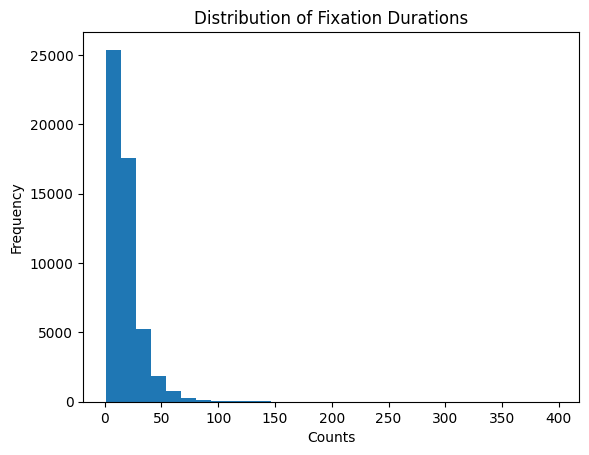

In [ ]:
# histogram plot to visualize the distribution of the fixations durations, or counts
plt.hist(fixation_rows['count'], bins=30)
plt.title('Distribution of Fixation Durations')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.show()

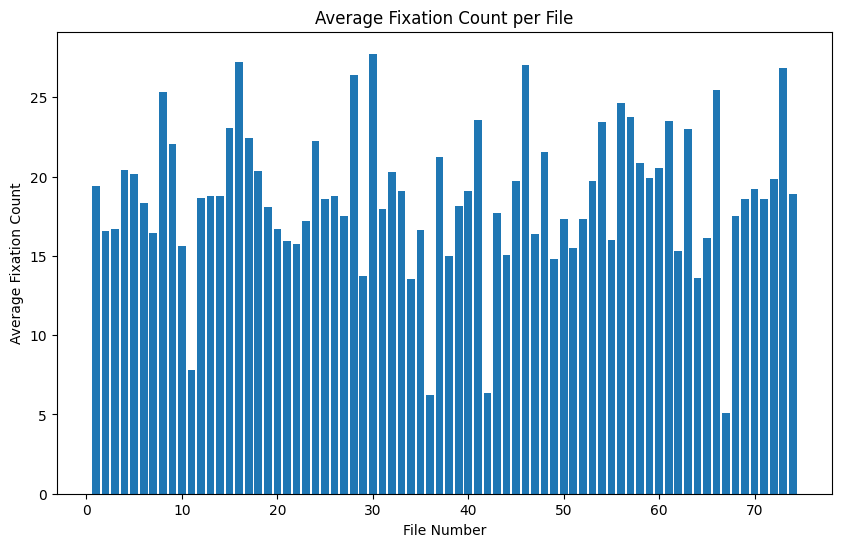

In [ ]:
# Calculate the average count for each file_number
average_counts = fixation_rows.groupby('file_number')['count'].mean()

# Visualizing the average counts using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(average_counts.index, average_counts.values)
plt.xlabel('File Number')
plt.ylabel('Average Fixation Count')
_ = plt.title('Average Fixation Count per File')

In [ ]:
# calculating the mean, std deviation, min, and max values for the fixation counts for each file_number
fixation_stats = fixation_rows.groupby('file_number')['count'].agg(['mean', 'std', 'min', 'max'])
print(fixation_stats)


                  mean        std  min  max
file_number                                
1            19.408488  13.911988    1  129
2            16.592186  10.606532    2  119
3            16.686695  11.642624    3  137
4            20.410511  11.394788    2  107
5            20.170270  16.717608    5  155
...                ...        ...  ...  ...
70           19.210235  13.885765    4  187
71           18.584639  15.721024    3  128
72           19.822443  11.624568    4  102
73           26.867596  21.375556    4  143
74           18.881333  17.771297    2  260

[74 rows x 4 columns]


*now*, im interested to see how these fixation findings relate to the conditions (weather, time, and locations) of each specific file_number

In [ ]:
design

,file_number,time,weather,location,D,train/test
0,1,Evening,Sunny,Countryside,D8,Training Set
1,2,Morning,Cloudy,Highway,D2,Training Set
2,3,Evening,Sunny,Highway,D3,Training Set
3,4,Night,Sunny,Downtown,D2,Training Set
4,5,Morning,Cloudy,Countryside,D7,Training Set
...,...,...,...,...,...,...
69,70,Morning,Rainy,Downtown,D3,Test Set
70,71,Night,Cloudy,Highway,D6,Test Set
71,72,Evening,Cloudy,Downtown,D2,Test Set
72,73,Night,Sunny,Countryside,D7,Test Set


In [ ]:
design_fixation = pd.merge(fixation_rows, design, on='file_number')
design_fixation = design_fixation.drop(['event_type', 'D'], axis=1)
print(design_fixation.head())

design_fixation

  file_number event_number  count     time weather     location    train/test
0           1     Fixation      1  Evening   Sunny  Countryside  Training Set
1           1     Fixation     40  Evening   Sunny  Countryside  Training Set
2           1     Fixation     23  Evening   Sunny  Countryside  Training Set
3           1     Fixation      7  Evening   Sunny  Countryside  Training Set
4           1     Fixation      9  Evening   Sunny  Countryside  Training Set


,file_number,event_number,count,time,weather,location,train/test
0,1,Fixation,1,Evening,Sunny,Countryside,Training Set
1,1,Fixation,40,Evening,Sunny,Countryside,Training Set
2,1,Fixation,23,Evening,Sunny,Countryside,Training Set
3,1,Fixation,7,Evening,Sunny,Countryside,Training Set
4,1,Fixation,9,Evening,Sunny,Countryside,Training Set
...,...,...,...,...,...,...,...
51466,74,Fixation,15,Morning,Rainy,Downtown,Test Set
51467,74,Fixation,49,Morning,Rainy,Downtown,Test Set
51468,74,Fixation,14,Morning,Rainy,Downtown,Test Set
51469,74,Fixation,51,Morning,Rainy,Downtown,Test Set


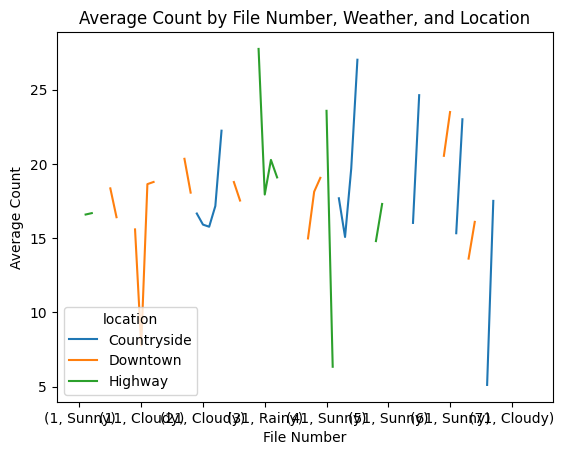

In [ ]:
# i want to see how the average fixation count related to the weather, and location
avg_fixation_count = design_fixation.groupby(['file_number', 'weather', 'location'])['count'].mean().unstack()


avg_fixation_count.plot(kind='line')
plt.xlabel('File Number')
plt.ylabel('Average Count')
_ = plt.title('Average Count by File Number, Weather, and Location')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
fixation_stats_design = pd.merge(design, fixation_stats, on='file_number')
fixation_stats_design

,file_number,time,weather,location,D,train/test,mean,std,min,max
0,1,Evening,Sunny,Countryside,D8,Training Set,19.408488,13.911988,1,129
1,2,Morning,Cloudy,Highway,D2,Training Set,16.592186,10.606532,2,119
2,3,Evening,Sunny,Highway,D3,Training Set,16.686695,11.642624,3,137
3,4,Night,Sunny,Downtown,D2,Training Set,20.410511,11.394788,2,107
4,5,Morning,Cloudy,Countryside,D7,Training Set,20.170270,16.717608,5,155
...,...,...,...,...,...,...,...,...,...,...
69,70,Morning,Rainy,Downtown,D3,Test Set,19.210235,13.885765,4,187
70,71,Night,Cloudy,Highway,D6,Test Set,18.584639,15.721024,3,128
71,72,Evening,Cloudy,Downtown,D2,Test Set,19.822443,11.624568,4,102
72,73,Night,Sunny,Countryside,D7,Test Set,26.867596,21.375556,4,143


<Figure size 1000x600 with 0 Axes>

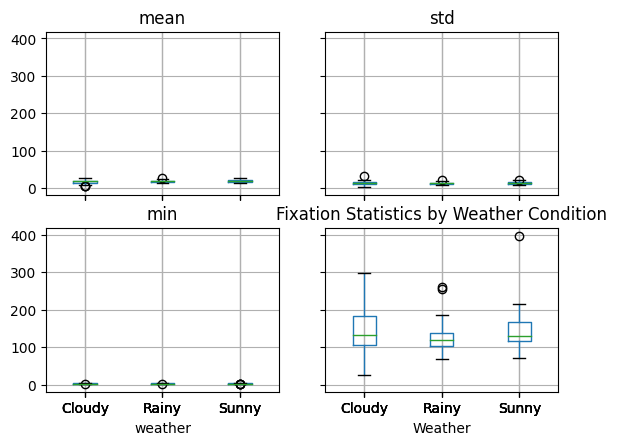

In [ ]:
plt.figure(figsize=(10, 6))
fixation_stats_design.boxplot(column=['mean', 'std', 'min', 'max'], by='weather')
plt.title('Fixation Statistics by Weather Condition')
plt.xlabel('Weather')
plt.ylabel('Fixation Statistic')
plt.suptitle('')
plt.show()


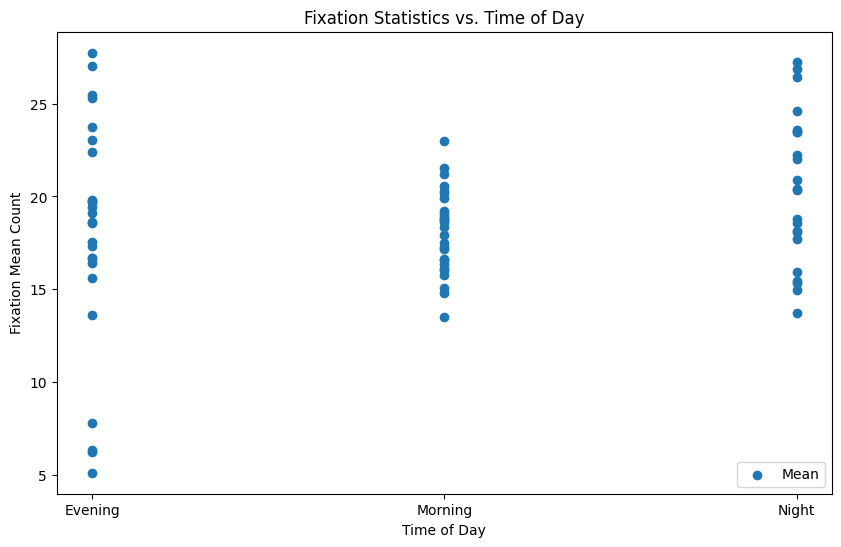

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(fixation_stats_design['time'], fixation_stats_design['mean'], label='Mean')
plt.title('Fixation Statistics vs. Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Fixation Mean Count')
plt.legend()
plt.show()



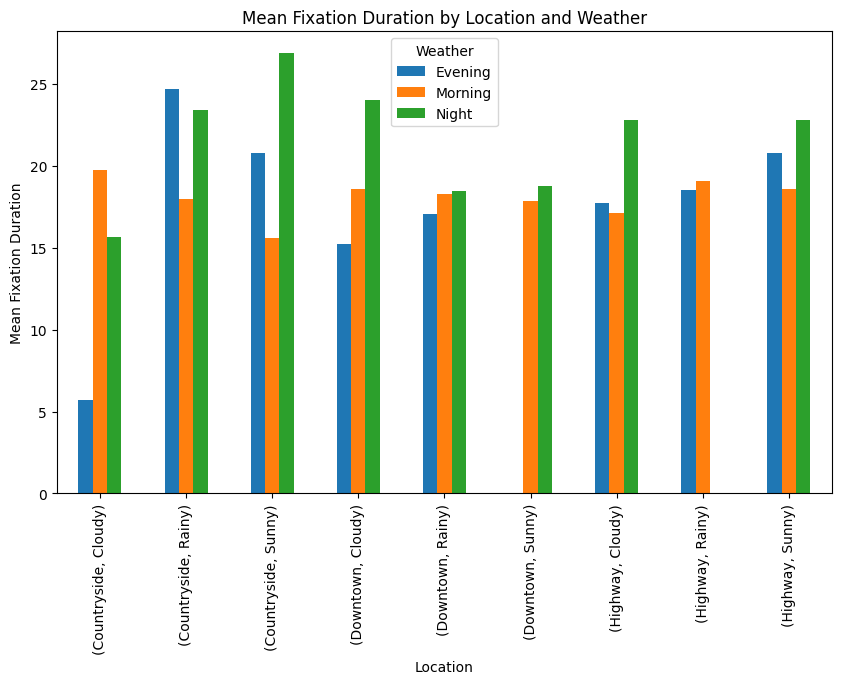

In [ ]:
mean_by_location_weather = fixation_stats_design.groupby(['location', 'weather', 'time'])['mean'].mean().unstack()
mean_by_location_weather.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Fixation Duration by Location and Weather')
plt.xlabel('Location')
plt.ylabel('Mean Fixation Duration')
plt.legend(title='Weather')
plt.show()